# Wuhan forecast 
## Author: Wentworth Liu
### Decicated for academic use only

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:


# Replace with the latest version of "丁香园" web link
target = 'https://3g.dxy.cn/newh5/view/pneumonia?scene=2&clicktime=1579582238&enterid=1579582238&from=timeline&isappinstalled=0'
req = requests.get(url=target)
req.encoding = 'urf-8'
html = req.text
soup = BeautifulSoup(html, 'html.parser')

provinces = soup.find(id='getListByCountryTypeService1')
type(provinces)
data_regexp = re.compile("\[(.*?)\]")
a=re.findall(data_regexp,str(provinces))
a=a[0]
a=eval(a)
type(a)

data = {}
print('疫情：')
total = 0 
for province in a:
    try:
        
        name = province['provinceShortName']
        num = province['confirmedCount']
        if num == "":
            num = 0
        data['{}'.format(name)] = num
        total += num
    except AttributeError as e:
        continue
sorted_data={k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}
for k,v in sorted_data.items():
     print( k, '确诊', v, '例')
print('共计确诊：{} 例'.format(total))
# use when needed
# from datetime import datetime  
# from datetime import timedelta  
# datetime.today().date()
# daily_update = pd.DataFrame.from_dict(sorted_data,orient='index').rename(columns={0:str(datetime.today().date())})
# daily_update.to_csv('province_update.csv')

疫情：
湖北 确诊 33366 例
广东 确诊 1219 例
河南 确诊 1135 例
浙江 确诊 1131 例
湖南 确诊 946 例
安徽 确诊 889 例
江西 确诊 844 例
江苏 确诊 543 例
重庆 确诊 505 例
山东 确诊 497 例
四川 确诊 436 例
黑龙江 确诊 378 例
北京 确诊 352 例
上海 确诊 306 例
福建 确诊 272 例
河北 确诊 251 例
陕西 确诊 225 例
广西 确诊 222 例
云南 确诊 154 例
海南 确诊 151 例
贵州 确诊 131 例
山西 确诊 124 例
辽宁 确诊 116 例
天津 确诊 107 例
甘肃 确诊 86 例
吉林 确诊 83 例
内蒙古 确诊 60 例
新疆 确诊 59 例
宁夏 确诊 58 例
香港 确诊 49 例
台湾 确诊 18 例
青海 确诊 18 例
澳门 确诊 10 例
西藏 确诊 1 例
共计确诊：44742 例


In [3]:
#use when saving new daily provincial data is needed
from datetime import datetime  
from datetime import timedelta  
datetime.today().date()
daily_update = pd.DataFrame.from_dict(sorted_data,orient='index').rename(columns={0:str(datetime.today().date())})
daily_update.to_csv('provincial output\province_update_{}.csv'.format(str(datetime.today().date())), encoding='utf_8_sig')

## Forecast the development of disease

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            Conincrease   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     67.08
Date:                Tue, 11 Feb 2020   Prob (F-statistic):           2.45e-09
Time:                        23:04:39   Log-Likelihood:                -163.56
No. Observations:                  22   AIC:                             333.1
Df Residuals:                      19   BIC:                             336.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               392.8110    170.94

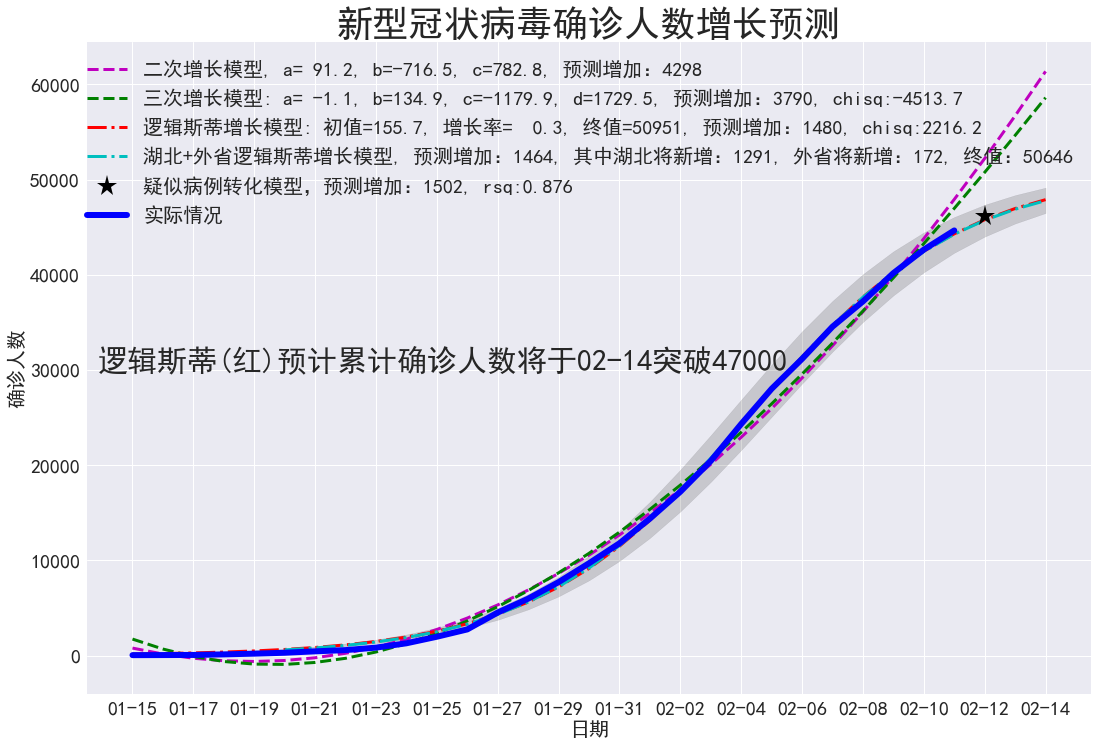

In [6]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
from scipy.stats import chisquare

df = pd.read_excel('virus.xlsx', sheet_name='Sheet1')
# Get the rapid growth part
rapid_growth=df.iloc[15:,:].reset_index(drop=True)
rapid_growth['Outside']=rapid_growth['Confirmed']-rapid_growth['Hubei']
# Fitting model candidates
# Model 1
def expfunc(x, a, b, c):
    return a * np.exp(b * x) + c
exppopt, exppcov = curve_fit(expfunc, rapid_growth.index.values, rapid_growth.Confirmed)
expsigma = np.sqrt(np.diagonal(exppcov))

explagpopt, explagpcov = curve_fit(expfunc, rapid_growth.index.values[:-1], rapid_growth.Confirmed[:-1])

# Model 2
def ployfunc(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d
#      return a * x**2 + b * x**1 + c 
polypopt, polypcov = curve_fit(ployfunc, rapid_growth.index.values, rapid_growth.Confirmed)
# Model 3
def ploy2func(x, a, b, c):
      return a * x**2 + b * x**1 + c 
poly2popt, poly2pcov = curve_fit(ploy2func, rapid_growth.index.values, rapid_growth.Confirmed)
# Model 4
# https://www.zhihu.com/question/36714044
def logistic(x, a, r, c): 
    """Logistic growth model. 
    """ 
    y = c*a*np.exp(x*r)/(c+a*(np.exp(x*r)-1))
    return y 
logpopt, logpcov = curve_fit(logistic, rapid_growth.index.values, rapid_growth.Confirmed)
logsigma = np.sqrt(np.diagonal(logpcov))
# Create n days ahead forecast

# Model 5 Hubei+ Outside
preHubei_Outside=rapid_growth[rapid_growth['Hubei'].isna()]
Hubei_Outside = rapid_growth[rapid_growth['Hubei'].notna()].reset_index(drop=True)
loghbpopt, loghbpcov = curve_fit(logistic, Hubei_Outside.index.values, Hubei_Outside.Hubei)
logospopt, logospcov = curve_fit(logistic, Hubei_Outside.index.values, Hubei_Outside.Outside)
from datetime import timedelta 

n = 3
index = pd.date_range(rapid_growth.Date.iloc[-1]+timedelta(1), periods=n, freq='D')
columns=['expforecast','polyforecast','logforecast']
hbindex = pd.date_range(Hubei_Outside.Date.iloc[-1]+timedelta(1), periods=n, freq='D')
hbcolumns=['loghbforecast','logosforecast']

forecast = pd.DataFrame(index=index,columns=columns)
forecast=forecast.reset_index().rename(columns={'index':'Date'})
forecast.index=forecast.index.values+len(rapid_growth.index.values)
rapid_growth=pd.concat([rapid_growth,forecast])


hbforecast= pd.DataFrame(index=hbindex,columns=columns)
hbforecast=hbforecast.reset_index().rename(columns={'index':'Date'})
hbforecast.index=hbforecast.index.values+len(Hubei_Outside.index.values)

Hubei_Outside=pd.concat([Hubei_Outside,hbforecast])
# save the lastest date that contains actual value
confirmedid = rapid_growth[rapid_growth.Confirmed.notnull()]['Confirmed'].idxmax()
latest_date = rapid_growth.iloc[confirmedid]['Date']

rapid_growth['expforecast']=expfunc(rapid_growth.index.values, *exppopt)
rapid_growth['explagforecast']=expfunc(rapid_growth.index.values, *explagpopt)
rapid_growth['polyforecast']=ployfunc(rapid_growth.index.values, *polypopt)
rapid_growth['logforecast']=logistic(rapid_growth.index.values, *logpopt)
rapid_growth['poly2forecast']=ploy2func(rapid_growth.index.values, *poly2popt)
Hubei_Outside['loghbforecast']=logistic(Hubei_Outside.index.values, *loghbpopt)
Hubei_Outside['logosforecast']=logistic(Hubei_Outside.index.values, *logospopt)
Hubei_Outside['log2forecast']=Hubei_Outside['loghbforecast'] + Hubei_Outside['logosforecast']
Hubei_Outside.index=Hubei_Outside.index.values+len(preHubei_Outside)
rapid_growth['log2forecast'] = Hubei_Outside['log2forecast']
expchi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.expforecast[:confirmedid])
explagchi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.explagforecast[:confirmedid])
polychi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.polyforecast[:confirmedid])
logchi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.logforecast[:confirmedid])
poly2chi = chisquare(rapid_growth.Confirmed[:confirmedid], f_exp=rapid_growth.poly2forecast[:confirmedid])

### Run quick linear regression to get the coefficient implied from suspected patient amount
ConSus = pd.DataFrame()
ConSus['Conincrease'] = rapid_growth.Confirmed.shift(-1)-rapid_growth.Confirmed
ConSus['Suspected'] = rapid_growth['Suspected']
ConSus['Suspectedincrease'] = rapid_growth.Suspected-rapid_growth.Suspected.shift(1)

ConSuscomplete=ConSus.dropna()
y = ConSuscomplete[['Conincrease']]
x = ConSuscomplete[['Suspected','Suspectedincrease']]
# Add the column of ones to the inputs
x = sm.add_constant(x)
# Create a model and fit it
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())
sus_test = [1., ConSus.iloc[confirmedid][['Suspected','Suspectedincrease']].tolist()]
sus_test
flattened = []
for sublist in sus_test:
    if type(sublist)!=list:
        flattened.append(sublist)
    else:
        for val in sublist:
            flattened.append(val)

# ConSus.iloc[confirmedid]['Suspected']
results.predict(flattened)
increase_pred = results.predict(flattened)
ConSus_plot=increase_pred+rapid_growth.iloc[confirmedid]['Confirmed']

simplex = rapid_growth.Date.apply(lambda x:str(x.date())[5:])
# Plot
# -*- coding: utf-8 -*
from pylab import text
import matplotlib.pyplot as plt
from scipy.optimize import bisect
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.figure(figsize=(18,12))
# plt.plot(simplex, rapid_growth['expforecast'], 'y--',label='指数增长模型: a=%5.1f, b=%5.1f, c=%5.1f' % tuple(exppopt)+', 今日预测：{}, chisq:{}'.format(int(rapid_growth.expforecast[confirmedid+1]),round(expchi[0],1)))
plt.plot(simplex, rapid_growth['poly2forecast'], 'm--',label='二次增长模型, a=%5.1f, b=%5.1f, c=%5.1f' % tuple(poly2popt) +', 预测增加：{}'.format(int(rapid_growth.poly2forecast.diff()[confirmedid+1]), round(poly2chi[0],1)),linewidth=3)

# plotting the confidence intervals
bound_upper = logistic(rapid_growth.index.values, *(logpopt + logsigma))
bound_lower = logistic(rapid_growth.index.values, *(logpopt - logsigma))
plt.fill_between(simplex, bound_lower, bound_upper , color='black', alpha = 0.15)

# solve the equation of expfunc given specific value
threshold = 47000
def f(x):
    return logistic(x,*logpopt) - threshold
predicted_date = rapid_growth.iloc[rapid_growth.index.values[math.ceil(bisect(f, 5, 30))]]['Date']
plt.figtext(.4, .5, "逻辑斯蒂(红)预计累计确诊人数将于{}突破{}".format(str(predicted_date)[5:10], threshold),fontsize='30',ha='center')


rapid_growth.to_csv('provincial output\predction_update_{}.csv'.format(str(datetime.today().date())))
# plt.figtext(.15, .8, "指数模型, 二次模型chisq:{}".format(round(expchi[0],1),round(polychi[0],1)))
plt.plot(simplex, rapid_growth['polyforecast'], 'g--',label='三次增长模型: a=%5.1f, b=%5.1f, c=%5.1f, d=%5.1f' % tuple(polypopt)+', 预测增加：{}, chisq:{}'.format(int(rapid_growth.polyforecast.diff()[confirmedid+1]), round(polychi[0],1)),linewidth=3)
plt.plot(simplex, rapid_growth['logforecast'], 'r-.',label='逻辑斯蒂增长模型: 初值=%5.1f, 增长率=%5.1f, 终值=%5.0f' % tuple(logpopt)+', 预测增加：{}, chisq:{}'.format(int(rapid_growth.logforecast.diff()[confirmedid+1]),round(logchi[0],1)),linewidth=3)
plt.plot(simplex, rapid_growth['log2forecast'], 'c-.',label='湖北+外省逻辑斯蒂增长模型, 预测增加：{}, 其中湖北将新增：{}, 外省将新增：{}, 终值：{}'.format(int(Hubei_Outside.log2forecast.diff()[confirmedid+1]), int(Hubei_Outside['loghbforecast'].diff().iloc[-n]), int(Hubei_Outside['logosforecast'].diff().iloc[-n]), int(loghbpopt[-1]+logospopt[-1])),linewidth=3)
plt.plot(str(rapid_growth.Date[confirmedid+1].date())[5:], ConSus_plot,'k*',markersize=22,label='疑似病例转化模型，预测增加：{}, rsq:{}'.format( int(increase_pred[0]),round(results.rsquared,3)))
plt.plot(simplex, rapid_growth.Confirmed, 'b-', label='实际情况', linewidth=6)
plt.legend(prop={'size': 20})

import matplotlib.ticker as plticker


ax = plt.gca()
loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel("确诊人数", fontsize=20)

plt.xlabel("日期", fontsize=20)
plt.title("新型冠状病毒确诊人数增长预测", fontsize=36)
plt.savefig("新型冠状病毒确诊人数增长预测.png")
plt.show()

In [12]:
rapid_growth

,Confirmed,Cured_change,Date,Dead_change,Hubei,Outside,Suspected,expforecast,logforecast,polyforecast,explagforecast,poly2forecast,log2forecast
0,41.0,NaN,2020-01-15,NaN,NaN,NaN,NaN,-1623.050758,132.060714,803.330256,-1304.035531,1571.295266,NaN
1,50.0,NaN,2020-01-16,NaN,NaN,NaN,NaN,-1353.243939,177.448537,311.909744,-1081.894580,695.892208,NaN
2,62.0,NaN,2020-01-17,NaN,NaN,NaN,NaN,-1046.171694,238.358092,-54.767179,-825.356580,28.707209,NaN
3,121.0,NaN,2020-01-18,NaN,NaN,NaN,NaN,-696.686961,320.035253,-289.111925,-529.095376,-430.259732,NaN
4,198.0,NaN,2020-01-19,NaN,NaN,NaN,40.0,-298.931775,429.449086,-383.535904,-186.960095,-681.008614,NaN
5,291.0,0.0,2020-01-20,0.0,270.0,21.0,127.0,153.760928,575.818276,-330.450528,208.152560,-723.539436,530.625383
6,440.0,2.0,2020-01-21,1.0,375.0,65.0,260.0,668.979058,771.266825,-122.267210,664.445783,-557.852200,720.049962
7,571.0,4.0,2020-01-22,3.0,444.0,127.0,393.0,1255.358560,1031.614946,248.602639,1191.392978,-183.946905,975.398511
8,830.0,6.0,2020-01-23,8.0,549.0,281.0,1072.0,1922.728165,1377.286775,789.747607,1799.934442,398.176449,1318.200037
9,1287.0,3.0,2020-01-24,16.0,729.0,558.0,1965.0,2682.274140,1834.268852,1508.756283,2502.704506,1188.517862,1775.879503


#### Quick look at the relation between 
` y = ConSuscomplete[['Conincrease']]
x = ConSuscomplete[['Suspected']]
`

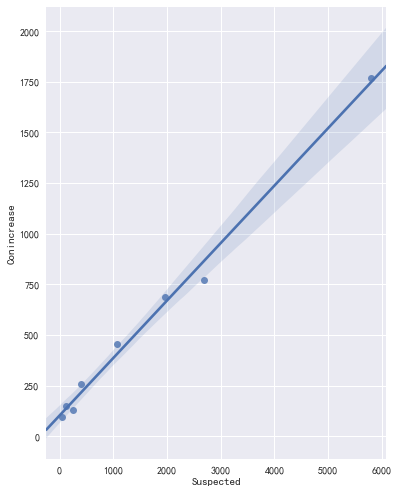

In [32]:
import seaborn as sns

%matplotlib inline

sns.pairplot(ConSuscomplete, x_vars=['Suspected'], y_vars='Conincrease', size=7, aspect=0.8, kind='reg')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0.5, 0, '日期')

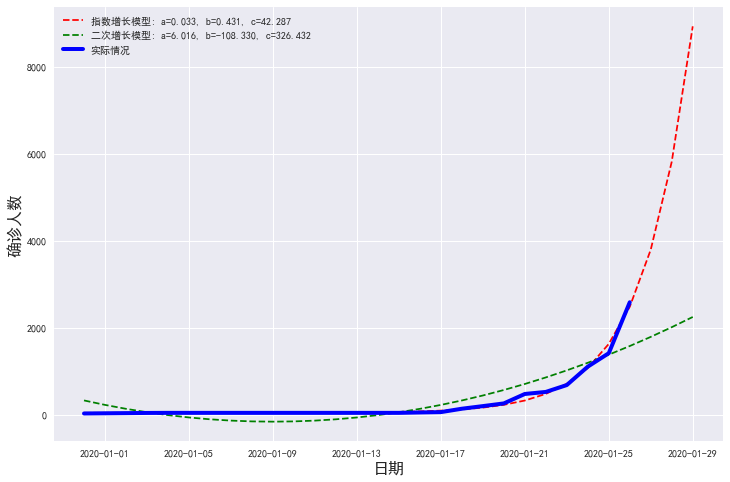

In [34]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
df = pd.read_excel('virus.xlsx', sheet_name='Sheet1')
# Get the rapid growth part
rapid_growth=df.reset_index(drop=True)

# Fitting model candidates
def expfunc(x, a, b, c):
    return a * np.exp(b * x) + c
exppopt, exppcov = curve_fit(expfunc, rapid_growth.index.values, rapid_growth.Confirmed)
def ployfunc(x, a, b, c):
    return a * x**2 + b * x + c
polypopt, polypcov = curve_fit(ployfunc, rapid_growth.index.values, rapid_growth.Confirmed)

# Create n days ahead forecast
from datetime import timedelta 

n = 3
index = pd.date_range(rapid_growth.Date.iloc[-1]+timedelta(1), periods=n, freq='D')
columns=['expforecast','polyforecast']
forecast = pd.DataFrame(index=index,columns=columns)

forecast=forecast.reset_index().rename(columns={'index':'Date'})
forecast.index=forecast.index.values+len(rapid_growth.index.values)
rapid_growth=pd.concat([rapid_growth,forecast])

# Plot
# -*- coding: utf-8 -*
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.figure(figsize=(12,8))
plt.plot(rapid_growth.Date, expfunc(rapid_growth.index.values, *exppopt), 'r--',label='指数增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(exppopt))
plt.plot(rapid_growth.Date, ployfunc(rapid_growth.index.values, *polypopt), 'g--',label='二次增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(polypopt))
plt.plot(rapid_growth.Date, rapid_growth.Confirmed, 'b-', label='实际情况', linewidth=4)
plt.legend()
plt.ylabel("确诊人数", fontsize=16)
plt.xlabel("日期", fontsize=16)

### Epidemic model
- SIR model with Python
> https://www.youtube.com/watch?v=wEvZmBXgxO0
- The SIR epidemic model
> https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
- epirecipes
> http://epirecip.es/epicookbook/chapters/sir/python

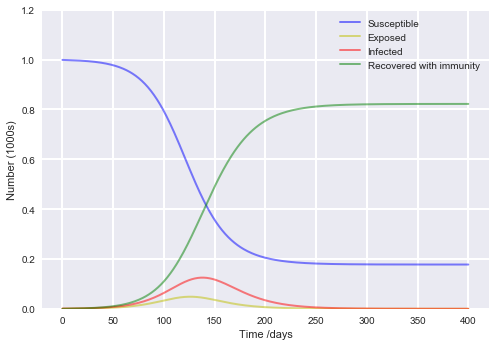

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, E0, R0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - E0 - I0 - R0
# Contact rate, beta; exposed period sigma = 1 / 5; and mean recovery rate, gamma, (in 1/days).
beta, sigma, gamma = 0.15, 0.2, 1./14 
# A grid of time points (in days)
t = np.linspace(0, 400, 400)

# The SIR model differential equations.
def deriv(y, t, N, beta, sigma ,gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, sigma, gamma))
S, E, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
plt.style.use("seaborn")
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [64]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, E0, R0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - E0 - I0 - R0
# Contact rate, beta; exposed period sigma = 1 / 5; and mean recovery rate, gamma, (in 1/days).
# beta, sigma, gamma = 0.15, 0.2, 1./14 
# A grid of time points (in days)
t = np.linspace(0, 400, 400)

# The SIR model differential equations.
def deriv(yd, t, N, beta, sigma ,gamma):
    S, E, I, R = yd
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

# Initial conditions vector
# y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
def yfunc(t, beta, sigma, gamma, y0):
    y = odeint(deriv, y0, t, args=(N, beta, sigma, gamma))
    return y

# exppopt, exppcov = curve_fit(expfunc, rapid_growth.index.values, rapid_growth.Confirmed)
popt, cov = curve_fit(yfunc, rapid_growth.index.values.astype('float'), rapid_growth[['Confirmed','Suspected','Cured_change','Dead_change']].astype('float').to_numpy()) 

ValueError: not enough values to unpack (expected 4, got 1)

In [62]:
a,b,c,d =rapid_growth[['Confirmed','Suspected','Cured_change','Dead_change']].astype('float').to_numpy()[1]

In [69]:
rapid_growth['S'] = 10000000 - rapid_growth['Confirmed']

In [72]:
from symfit import variables, parameters, Fit, D, ODEModel
# Total population, N.
N = 10000000
# # Initial number of infected and recovered individuals, I0 and R0.
# I0, E0, R0 = 1, 0, 0
# # Everyone else, S0, is susceptible to infection initially.
# S0 = N - E0 - I0 - R0

S, E, I, R, t = variables('S, E, I, R, t')
N, beta, sigma ,gamma = parameters('N, beta, sigma ,gamma')

model_dict = {

    D(S, t): -beta * S * I / N,
    D(E, t): beta * S * I / N - sigma * E,
    D(I, t): sigma * E - gamma * I,
    D(R, t): gamma * I

}

ode_model = ODEModel(model_dict, initial={t: 0.0, N: 10000000, S: 10000000-15, E:0, I: 15, R:0})


fit = Fit(ode_model, t=rapid_growth.index.values, I=rapid_growth.Confirmed, S=rapid_growth['S'] , E=rapid_growth.Suspected, R=rapid_growth.Cured_change+rapid_growth.Dead_change)
fit_result = fit.execute()

KeyError: (None, Ellipsis)

In [74]:
from symfit import Parameter
tdata = np.array([10, 26, 44, 70, 120])
adata = 10e-4 * np.array([44, 34, 27, 20, 14])
a, b, t = variables('a, b, t')
k = Parameter('k', 0.1)
a0 = 54 * 10e-4

model_dict = {
    D(a, t): - k * a**2,
    D(b, t): k * a**2,
}

ode_model = ODEModel(model_dict, initial={t: 0.0, a: a0, b: 0.0})

fit = Fit(ode_model, t=tdata, a=adata, b=None)
fit_result = fit.execute()

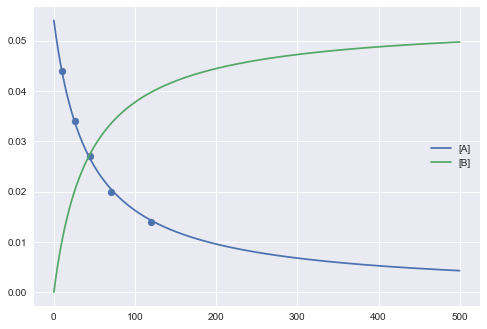

In [77]:
# Generate some data
tvec = np.linspace(0, 500, 1000)

A, B = ode_model(t=tvec, **fit_result.params)
plt.plot(tvec, A, label='[A]')
plt.plot(tvec, B, label='[B]')
plt.scatter(tdata, adata)
plt.legend()
plt.show()

C:\Users\WENTWORTHLIU\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return output


a = 0.00213178
b = 6.33105
y0 = -2.2092


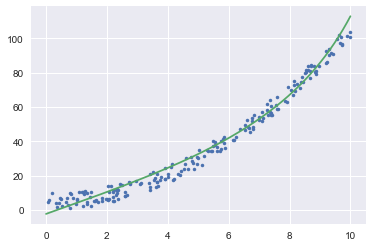

In [46]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit

def f(y, t, a, b):
    return a*y**2 + b

def y(t, a, b, y0):
    """
    Solution to the ODE y'(t) = f(t,y,a,b) with initial condition y(0) = y0
    """
    y = odeint(f, y0, t, args=(a, b))
    return y.ravel()

# Some random data to fit
data_t = np.sort(np.random.rand(200) * 10)
data_y = data_t**2 + np.random.rand(200)*10

popt, cov = curve_fit(y, data_t, data_y, [-1.2, 0.1, 0])
a_opt, b_opt, y0_opt = popt

print("a = %g" % a_opt)
print("b = %g" % b_opt)
print("y0 = %g" % y0_opt)

import matplotlib.pyplot as plt
t = np.linspace(0, 10, 2000)
plt.plot(data_t, data_y, '.',
         t, y(t, a_opt, b_opt, y0_opt), '-')
plt.gcf().set_size_inches(6, 4)
plt.savefig('out.png', dpi=96)
plt.show()